<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [1649]:
%%capture
pip install pyswarms

In [1650]:
%%capture
!pip install numpy==1.26

In [1651]:
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [1652]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1653]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 20000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 730 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 4000 # Valor para o custo da manutenção preventiva

In [1654]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [1655]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [1656]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [1657]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [1658]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [1659]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [1660]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [1661]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [1662]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario01.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario02.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario03.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario04.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/Cenarios/cenario04.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,1033,1,6,0,1.0,182
1,1309,1,7,0,1.0,366
2,1778,1,7,0,1.0,547
3,2342,1,10,0,1.0,731
4,3254,1,14,0,1.0,912




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [1663]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [1664]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [1665]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-22 00:26:42,958 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-.0846
2023-10-22 00:26:43,267 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.08458294572616092, best pos: [149.1333434    1.00083456   0.65323625]



Melhores valores para λ, β, θ : [149.1333434    1.00083456   0.65323625]


In [1666]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 149.13334340187373
beta: 1.0008345615005512
theta: 0.6532362489521314


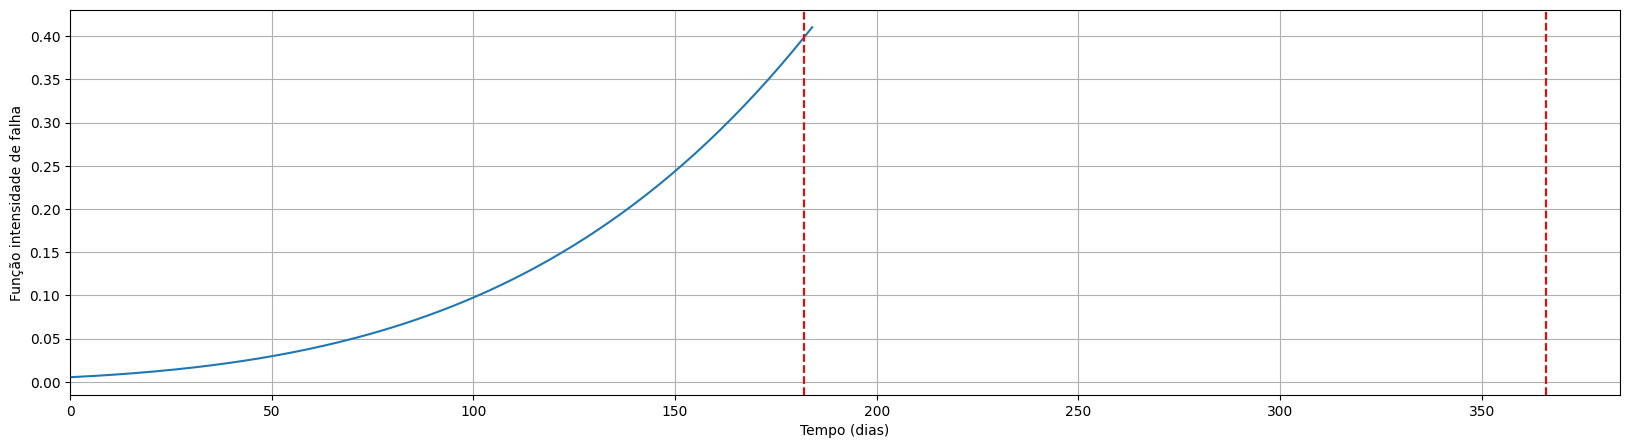

Fator ajuste:  [0.4796409625107464, 0.4796409625107464, 0.4796409625107464, 0.4796409625107464, 0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.4796409625107464, 0.27864084015710067, 0.4796409625107464, 0.27864084015710067, 0.4796409625107464, 0.4796409625107464, 0.4796409625107464]


In [1667]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [1668]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [1669]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-22 00:26:44,886 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=1.53e+5



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 79, 115, 129, 214, 262, 358, 521, 563, 621, 655, 668]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067]
Media de falhas:  [0, 0.04160161668923838, 0.07686882517334495, 0.13968053614299303, 3.7096110457006426, 7.128078412029353, 20.773809182335118, 185.75615456427425, 257.09456117603816, 520.4633596727521, 724.5950196447199, 749.0987839557906, 1294.260245846665]
Custo =  364274.8015633718


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 81, 142, 187, 288, 316, 348, 369, 529, 606, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25

pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=1.09e+5



Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 68, 119, 140, 169, 215, 305, 351, 622, 658, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067]
Media de falhas:  [0, 0.019644799001198754, 0.08395729455062406, 0.2093802866243097, 0.5700492684700126, 2.015508238007146, 8.754499671950855, 19.855635307498396, 545.0759917712332, 764.2187578609758, 1002.9838520899754, 1108.1487409301992]
Custo =  278734.6470913803


Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 62, 95, 170, 208, 235, 322, 552, 612]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.278640840

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=1.09e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 42, 107, 131, 171, 207, 212, 314, 331, 440, 489, 537, 583, 614, 656, 685]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 0.0017622855408672082, 0.06854850353220274, 0.25561381345327083, 0.55125954389664, 1.129483163283111, 1.2243680890953461, 14.718439367983821, 18.251823566596443, 53.66481441116074, 99.71114604418118, 166.09891421821493, 214.59065885423223, 291.15352709014905, 362.7448543876469, 574.2892248559223, 692.1270865341091]
Custo =  276665.8307075746


Nú

pyswarms.single.global_best:  55%|█████▌    |55/100, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 2, 30, 60, 96, 142, 170, 198, 242, 329, 405, 433, 485, 569, 577, 615, 656]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 4.260518325920225e-10, 0.00027809844527415187, 0.005170692736530702, 0.06779014657166992, 0.3216120163817912, 0.9584070789403052, 1.3386504909785335, 2.6569899859923396, 17.094887350900095, 34.971152014056194, 66.37328478414327, 92.2461497513164, 170.2189280500794, 178.64058459182664, 271.8998300041492, 341.8474506587

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 60, 170, 207, 223, 409, 491, 539, 585, 616, 648, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067]
Media de falhas:  [0, 1.0195774388402635e-05, 0.005551416000910778, 1.1506666954800233, 2.180542946415045, 2.541542185876967, 69.38493092065218, 111.30758319630203, 178.71504649217482, 227.8833525513401, 305.4642991720574, 357.8442925586944, 664.020319117875, 769.1852079580989]
Custo =  264418.5752040036


Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 20, 61, 170, 209, 248, 318, 400, 441, 488, 539, 581, 608, 650, 663]
Severidade 

pyswarms.single.global_best:  64%|██████▍   |64/100, best_cost=1.09e+5<ipython-input-1668-3f464f4b430c>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  78%|███████▊  |78/100, best_cost=1.09e+5

Custo =  240944.26760406172


Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 40, 137, 171, 195, 411, 424, 488, 567, 571, 623, 654]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 0.0013805157435352374, 0.30871831923509435, 1.0616531896329544, 1.6164755252584784, 59.07905065702745, 66.53898337489761, 98.85319436918692, 227.87025872846678, 231.92818533246577, 363.1354749682605, 415.85001941043924, 1064.335635542683]
Custo =  256754.39063930998


Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 0, 55, 60, 171, 205, 319, 488, 539, 542, 574, 615, 652]
Severidade para cada subsistema: [0.5, 0.

pyswarms.single.global_best:  92%|█████████▏|92/100, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 0, 60, 142, 170, 198, 236, 251, 483, 568, 584, 608, 653]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 0.0, 0.010501043413451327, 0.4265198102514677, 0.785358837076837, 1.4609934581612884, 2.4965654712927554, 3.516480008395223, 235.65774176890127, 313.95158708596443, 331.46540308779544, 389.18449697143393, 464.2877853323763, 1119.9070443457363]
Custo =  inf


Número de ciclos de manutenção: 10 2
Tempos para manutenções preventivas: [0, 143, 170, 197, 253, 485, 538, 576, 615, 647, 682]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.09e+5
2023-10-22 00:26:46,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54934539 1.92724319 3.1159078  0.38341103 3.69106846 5.70079276
 3.98764046 6.7196157  5.19939839 2.60691521 5.94202641 2.92815726
 4.77285752 0.77617882 0.58172635 3.75773196 5.46065273 3.81532141
 6.53422434 5.38970219 2.06510291 5.33931771 6.53300999 0.78973085]
2023-10-22 00:26:46,473 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 2
Tempos para manutenções preventivas: [0, 170, 203, 423, 481, 617, 652, 681]
Severidade para cada subsistema: [0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.5]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067]
Media de falhas:  [0, 1.9257865980448212, 2.210560588965735, 67.69197554135947, 117.64371106967536, 615.2269623007036, 673.7950109290875, 880.3533395416819, 1008.2670166398634]
Custo =  244646.33463117195


Número de ciclos de manutenção: 8 2
Tempos para manutenções preventivas: [0, 118, 149, 170, 204, 392, 482, 620, 655]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.55103025 1.92806106 3.11591194 0.3770311  3.79732219 5.69526064
 3.98542764 6.71961141 5.19546018 2.606479   4.88169217 2.92812069
 4.77304472 0.81843004 0.58216693 3.75553647 5.45822984 3.81515339
 6.53067705 5.38958295 2.06486113 5.3387275  6.53328618 0.78896737]
2023-10-22 00:26:46,491 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 3, 61, 170, 198, 318, 405, 489, 538, 584, 610, 646, 683, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 3.2408096839028386e-09, 0.010122219365065369, 1.1446632941746033, 1.8202979152590548, 12.578344294382577, 47.06652308983055, 89.259037292959, 157.41239775959446, 206.2415427391469, 269.36674350828736, 327.34836457532674, 589.0751960328961, 640.1300059891898, 706.7019311469367]
Custo =  296760.07917643036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5507515  1.92806976 3.11591327 0.37247333 3.77323042 5.69288301
 3.98638462 6.71961905 5.19838657 2.60641768 0.11593253 2.92813389
 4.77199237 3.89679451 0.58188664 3.75595946 5.46382109 3.81519551
 6.53055505 5.3896939  2.06486452 5.3397946  6.5334581  0.78985039]
2023-10-22 00:26:46,527 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 10, 62, 90, 170, 199, 311, 403, 488, 533, 548, 585, 608, 640, 698]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 1.3403836653692202e-06, 0.008271301554091264, 0.03335069389228898, 0.8842344104255493, 1.5952611902028395, 10.742832940359758, 46.10647002979859, 176.10844667536594, 236.8362160208652, 249.5628873900531, 323.76718720932115, 379.18753780000907, 429.0071139675538, 856.4404101921086, 941.1349092891072]
Custo =  305616.9942654455


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5501532  1.92801198 3.1159136  0.3699427  3.72779891 5.69196801
 3.98746986 6.71962591 5.20119775 2.60650647 2.77845315 2.92814775
 4.77108504 0.60490144 0.58162594 3.75652376 5.46882816 3.81523884
 6.53052181 5.38979612 2.06487389 5.34070843 6.53357825 0.79063618]
2023-10-22 00:26:46,541 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 17, 64, 96, 145, 170, 202, 217, 323, 449, 489, 529, 585, 610, 635, 690]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 1.907371778552721e-05, 0.0073518358011814555, 0.04397497174046881, 0.3355814163331925, 0.6613925895103685, 2.126917317628017, 2.430779283988391, 18.103242010992044, 62.46150361081918, 83.2849292812648, 136.16894669670302, 195.51025340661698, 256.32320784889885, 294.29097928750906, 683.4060277483065, 788.5709165885304]
Custo =  260453.31016144127


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,553 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54953611 1.92781945 3.11591329 0.36773167 3.6807611  5.69323722
 3.98847011 6.71963184 5.20334477 2.60663785 5.15318894 2.92816029
 4.77073094 5.36915093 0.58140546 3.75722354 5.47135566 3.81528425
 6.53122762 5.38988396 2.0649223  5.34125188 6.5335754  0.79134256]
2023-10-22 00:26:46,555 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 23, 34, 65, 118, 170, 205, 314, 398, 420, 473, 490, 525, 585, 612, 631]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 8.657205513617083e-05, 0.00016925398150452188, 0.007175527759106188, 0.2010737739041753, 0.7975173209966657, 1.7414550491414849, 10.968913603040829, 42.11993662340163, 53.97145183025456, 77.77354716817138, 95.10212384095749, 140.43864166922606, 203.81304279114116, 270.1160850755055, 298.41958417956243, 1103.1423330017496]
Custo =  257144.7741352527

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54893916 1.92760331 3.11591178 0.36611572 3.6388083  5.69505114
 3.98920391 6.71963701 5.20481076 2.60682738 6.82620162 2.92817157
 4.77098481 3.39449198 0.58122759 3.75795562 5.47052671 3.81533234
 6.53204654 5.38993013 2.06501509 5.34145568 6.53342625 0.79191949]
2023-10-22 00:26:46,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 27, 47, 66, 146, 170, 208, 241, 328, 434, 467, 492, 524, 584, 619]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 0.00019312920172563452, 0.0008023981747890649, 0.0057924092384184275, 0.6300675683127863, 0.9446430015254788, 2.0191360343450695, 3.0051641826140063, 17.25982460775778, 49.864087666878255, 99.47993779675737, 147.28923196322245, 188.6839837074833, 251.62058678929637, 340.3010267995523, 619.3228295582654]
Custo =  172870.54404477892


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 28, 66, 94, 140, 170, 246, 303, 463, 493, 526, 582, 628]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 0.00023167820929635553, 0.005641982541437983, 0.03574463387477622, 0.27489712118672516, 0.4937632324107108, 6.702385344991108, 10.897234695468985, 75.01243718200139, 131.92884262432548, 175.19191602303846, 233.3102166670073, 354.5050217618067, 611.9964639820054]
Custo =  151759.70577232906


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,586 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54845585 1.92732753 3.11591027 0.3648191  3.60704763 5.69727816
 3.98942101 6.71963632 5.20612853 2.6070147  0.4439523  2.92818172
 4.77146966 1.91913662 0.58109266 3.75854856 5.46965182 3.81537516
 6.53281639 5.3899598  2.06511357 5.34117709 6.5331982  0.79213194]
2023-10-22 00:26:46,587 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,599 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5480388  1.92705966 3.1159086  0.36633293 3.59393922 5.69977626
 3.98947589 6.71963563 5.20642528 2.60716364 1.85504622 2.92818927
 4.77214773 1.05404334 0.58097468 3.75887023 5.46659797 3.81540224
 6.5338186  5.38



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 28, 65, 108, 170, 238, 250, 304, 330, 403, 461, 495, 529, 560, 580]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 0.00023167820929635553, 0.00514540855125827, 0.08147066280512244, 0.7691190195033981, 2.654248951050957, 3.088056295999596, 15.438143271587323, 18.245255677168743, 69.60143870535993, 111.51866552358587, 130.23608359601414, 175.75829685752115, 203.94263551975422, 244.00022123864466, 1343.364313970602]
Custo =  212947.10197114042


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,612 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54774764 1.92684534 3.11590694 0.37185671 3.58379738 5.70211603
 3.98903538 6.71963034 5.20528201 2.60729577 2.95149391 2.92819292
 4.7728316  0.92312706 0.58093345 3.7588879  5.46369322 3.81542634
 6.53480626 5.38988592 2.06526259 5.34019642 6.53273374 0.79113553]
2023-10-22 00:26:46,615 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 27, 64, 98, 171, 253, 318, 330, 443, 460, 496, 533, 579, 632]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 0.00019312920172563452, 0.00486473919058311, 0.04680474740393615, 0.8532545930907672, 3.7658222860307315, 9.551052075190038, 10.879255666271142, 115.42250358331859, 128.84225854157665, 197.52617723769112, 248.28918362189813, 295.44881205978453, 437.02382284863154, 684.919108452533]
Custo =  174608.47476684168


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,628 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54770986 1.92673423 3.11590569 0.37768544 3.60445788 5.70393134
 3.98846321 6.71962239 5.20345212 2.60736525 3.48506806 2.92819193
 4.77344715 1.47795932 0.58106552 3.75864427 5.46054044 3.81543524
 6.53559808 5.38982117 2.06527073 5.33959311 6.5325408  0.79018486]
2023-10-22 00:26:46,630 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 25, 63, 104, 133, 171, 255, 330, 460, 496, 537, 578, 636]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 0.00013139828505492594, 0.004786711167704523, 0.06746291271027738, 0.2001895215777659, 0.48144745227493735, 3.56282794042706, 11.27829670212044, 61.70442642996947, 98.60306069816065, 156.1202847915768, 198.05583279797537, 355.6961357025492, 593.9750258002813]
Custo =  141240.74539186904


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,644 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54793218 1.92670567 3.11590475 0.38445241 3.64344393 5.70505233
 3.987756   6.71961329 5.2011737  2.60729921 3.98812907 2.92818763
 4.77395928 2.64985953 0.58123983 3.7584153  5.45773648 3.81544019
 6.53624302 5.38973106 2.06523713 5.33903663 6.53238725 0.78928414]
2023-10-22 00:26:46,646 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 23, 62, 171, 231, 254, 330, 413, 445, 462, 496, 556, 578, 641]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 8.657205513617083e-05, 0.004725004145625902, 1.1661516009540867, 3.590793244353783, 4.456155245626319, 26.836378544467635, 47.89027267014326, 69.14704221908944, 76.38362548243208, 111.38886121100668, 204.9142560136649, 227.86015815065844, 550.1738084292315, 776.3998793911089]
Custo =  197998.88315524333


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,661 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54833497 1.92682941 3.11590452 0.39046553 3.68719415 5.70521254
 3.98709725 6.71960555 5.19880997 2.60718745 3.74935494 2.92818125
 4.77430952 3.98266442 0.58150989 3.75814047 5.45593249 3.81542326
 6.53653612 5.38964522 2.06517598 5.33859328 6.53227667 0.78858773]
2023-10-22 00:26:46,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 20, 61, 130, 171, 253, 326, 430, 466, 496, 579, 644]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 4.3016517204670066e-05, 0.004886616855481807, 0.25216225377892454, 0.7566245024804754, 5.326635511956536, 12.481485368242737, 43.31212084345614, 58.80229294669729, 117.15257677693174, 263.98036447078186, 364.92909142622517, 583.9043149729262]
Custo =  132604.74382650177


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,675 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5489136  1.92700172 3.11590447 0.39560054 3.72745689 5.70410351
 3.98657438 6.71959873 5.19677678 2.60706918 3.00808765 2.92817131
 4.77421564 5.36005881 0.58179726 3.75785658 5.45514993 3.81540387
 6.53666361 5.38957074 2.06510404 5.33834049 6.53224717 0.78823337]
2023-10-22 00:26:46,676 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 17, 61, 112, 171, 208, 252, 471, 495, 543, 580, 647]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.005581372612029934, 0.10806771681600533, 0.7849997279320104, 2.6359183693681842, 4.189175299779252, 142.25037993403794, 155.61931841535878, 225.1014265341273, 263.6265014976901, 456.12547468741536, 667.8341575540938]
Custo =  140183.9549387622


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 13, 62, 110, 143, 171, 206, 250, 315, 447, 476, 495, 581, 649]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 4.982202230908635e-06, 0.007284922468018404, 0.09760388137671269, 0.2974374419922286, 0.6651340950370681, 2.3695524296812263, 3.873478949048316, 13.360169376388392, 59.03270814120537, 84.57104304652066, 104.65492120326672, 258.2072697088234, 366.9428813565985, 573.7979462232706]
Custo =  129754.94472731282


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,689 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54954261 1.9271984  3.11590483 0.4001554  3.76302071 5.70287092
 3.98640318 6.71959398 5.19518321 2.60694075 2.22253901 2.92815971
 4.77404049 0.13071837 0.58204288 3.75757753 5.45444583 3.81536503
 6.53638446 5.38950466 2.06503916 5.33820357 6.53233927 0.78799779]
2023-10-22 00:26:46,691 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,706 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.55006038 1.92738469 3.11590564 0.40026183 3.79236882 5.70124686
 3.98640386 6.71959149 5.1940294  2.606825   1.88799869 2.92814878
 4.77371931 2.49744548 0.58225611 3.75734707 5.45530956 3.81531704
 6.53557229 5.38



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 10, 56, 62, 100, 142, 171, 205, 236, 248, 445, 494, 555, 582, 626, 649]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.3403836653692202e-06, 0.004751260555235565, 0.00620109784663182, 0.08358080378983944, 0.3194557625023115, 0.5364568750330189, 2.170025828900473, 3.023504287845157, 3.811231749533966, 151.39656181263615, 177.73704051969523, 349.87877273751303, 378.6773728316627, 440.64095158359544, 478.85458787482975, 1162.6895010347798]
Custo =  257343.6046456

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 9, 51, 63, 171, 204, 238, 246, 318, 391, 493, 536, 545, 583, 622, 647, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 7.911352521515275e-07, 0.0029918267450319987, 0.005813730866226639, 1.4900671138995611, 2.3701149831549535, 3.33425560189829, 3.852125052488574, 10.238656699373173, 25.156464691639826, 180.09192220331593, 212.44447758912372, 219.9698316869121, 294.9788436052536, 395.0268228281475, 435.96917326053494, 748.710199105250

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,724 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.55033636 1.92751627 3.11590667 0.39563223 3.81433975 5.69977988
 3.98653422 6.71959357 5.19354549 2.60674595 1.22659612 2.92814138
 4.77335805 5.1668209  0.58234693 3.75714447 5.45725519 3.81527417
 6.53446216 5.38946335 2.06493745 5.33863188 6.53289676 0.78786197]
2023-10-22 00:26:46,726 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 8, 48, 63, 170, 204, 244, 493, 533, 551, 583, 619, 644, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527]
Media de falhas:  [0, 4.3880813952869946e-07, 0.002266148093675509, 0.005656693121066643, 1.4443071825479048, 2.3468820904664174, 3.591537717800838, 190.11137229908414, 219.6191239744454, 235.17428273818757, 299.07856709628004, 469.71707890744756, 509.8999499753885, 842.1481786429097, 947.3130674831335]
Custo =  311887.7192739807


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,739 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.55032923 1.92758603 3.11590766 0.39121758 3.80199618 5.69870578
 3.98677182 6.71960165 5.19441851 2.60669517 0.16498152 2.9281367
 4.77299156 0.18489573 0.58228039 3.75702605 5.45953131 3.8152402
 6.53339922 5.38950797 2.06492496 5.33895733 6.53317576 0.78789957]
2023-10-22 00:26:46,741 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 8, 47, 64, 126, 170, 204, 242, 492, 529, 584, 618, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 4.3880813952869946e-07, 0.002020792556700319, 0.006029737637247459, 0.28845215783003136, 0.8096875661549872, 1.7122624740734997, 2.8587640532238607, 188.48890570074565, 215.04647877828094, 272.973713438281, 358.71324607093686, 395.0650080604029, 1133.8324529698325]
Custo =  227496.06973902544



2023-10-22 00:26:46,752 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.55025861 1.92761336 3.11590857 0.38505089 3.76975494 5.69820533
 3.98724486 6.7196118  5.19520634 2.60669561 5.77570446 2.92813356
 4.77262938 2.76152914 0.58221356 3.75697371 5.46166849 3.81522179
 6.53246693 5.38957282 2.06491427 5.33930696 6.53339409 0.78846303]
2023-10-22 00:26:46,754 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,765 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54997908 1.92755447 3.11590918 0.37916959 3.7240347  5.69845097
 3.98772009 6.71962156 5.19711835 2.60670586 3.86035962 2.9281328
 4.77233416 5.22981311 0.58213649 3.7570096  5.46347526 3.81523263
 6.53171287 5.38966973 2.06495233 5.33962454 6.53353826 0.78918293]
2023-10-22 00:26



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 9, 47, 64, 107, 149, 170, 205, 241, 419, 437, 479, 491, 527, 558, 584, 618, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 7.911352521515275e-07, 0.00191125434073393, 0.00592019942128107, 0.11787030182098171, 0.40654912299269785, 0.5624861021402482, 1.5064238302850672, 2.5773799805495994, 73.7825533212127, 79.89762655878229, 116.72170870431863, 140.47628140142592, 187.7366481966656, 215.51682827780462, 268.4

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,779 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5495901  1.92746603 3.11590934 0.37483198 3.68122602 5.69867668
 3.98812748 6.71962902 5.19901143 2.60677707 1.5628475  2.92813341
 4.77209078 0.37552237 0.58195599 3.75719276 5.46498334 3.81524355
 6.53144096 5.38976072 2.06499669 5.33983202 6.53365386 0.78999104]
2023-10-22 00:26:46,781 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 10, 50, 64, 170, 207, 242, 473, 491, 525, 583, 620, 635]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.3403836653692202e-06, 0.0025471093678665333, 0.005970244430727297, 1.437362150483136, 2.4672384014181574, 3.527574166292892, 150.69819405089632, 160.47649974666945, 204.61174115347535, 265.126534972814, 359.1477518768481, 382.1646670789582, 1160.8583214523726]
Custo =  241280.09399008218


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,793 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5491931  1.92734172 3.11590922 0.37339128 3.64323254 5.69945692
 3.98840664 6.71963539 5.20078895 2.60684842 6.19664536 2.92813749
 4.77207284 3.01172424 0.58178997 3.7575069  5.46538884 3.81525359
 6.53147138 5.38983947 2.0650545  5.33988767 6.53359048 0.79071519]
2023-10-22 00:26:46,794 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 13, 55, 64, 170, 209, 216, 244, 468, 492, 523, 550, 582, 624, 634]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 4.982202230908635e-06, 0.003725510967762681, 0.006086775328617847, 1.4374786813810265, 2.5577146634288384, 2.700041017845459, 4.3018977857838205, 141.4150165010417, 154.46011028466387, 194.3365083773665, 217.26153789718109, 280.7212274616382, 339.21207479651133, 354.54246569752, 1139.7870060057107]
Custo =  252348.67645264103


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,807 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54884984 1.92722556 3.1159089  0.37430837 3.61176051 5.70048975
 3.98863412 6.71964048 5.20208788 2.60692005 3.31546759 2.9281452
 4.77220147 5.73874744 0.58163965 3.75780448 5.46493011 3.81528261
 6.53196936 5.38990412 2.06511485 5.33982043 6.53336459 0.79113856]
2023-10-22 00:26:46,808 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 59, 64, 92, 123, 170, 245, 431, 464, 492, 522, 581, 628, 632]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.004820495690721991, 0.006220419651371616, 0.051048037399627, 0.15206045676284985, 0.49069223014798885, 2.82854419059594, 60.13598259491031, 74.13928003309383, 102.41528999034365, 140.78900733738865, 201.44707082837687, 325.05880599161355, 331.15450140965197, 1129.4134425308953]
Custo =  252289.80711496295


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,822 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54865601 1.92712334 3.11590831 0.37660089 3.58641808 5.70150417
 3.98857751 6.71964447 5.20319535 2.60698365 0.10394582 2.92815391
 4.77250526 0.80284355 0.58152719 3.75805299 5.46354607 3.81531726
 6.53288196 5.3899211  2.06516566 5.33962518 6.53311558 0.79123516]
2023-10-22 00:26:46,824 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 19, 63, 110, 171, 247, 402, 461, 492, 522, 580, 631]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.327823747272426e-05, 0.0061653134966878865, 0.0948969476073547, 0.7903904470926318, 3.23813486095835, 38.837768252739124, 62.58554828867464, 79.29446145430472, 117.66817880134973, 176.93129472016608, 312.7517349248078, 563.0478584558196]
Custo =  132777.01020489633


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,835 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54862106 1.92703514 3.11590765 0.37921351 3.56836381 5.70230449
 3.98836046 6.71964278 5.20351406 2.60702403 4.11291755 2.92816227
 4.77284998 3.35493998 0.581475   3.75820387 5.46150411 3.81534847
 6.53379585 5.38992675 2.06520215 5.33940213 6.53288919 0.79108144]
2023-10-22 00:26:46,837 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 21, 63, 112, 171, 248, 304, 411, 461, 493, 523, 580, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 5.4912366369779524e-05, 0.005658879266591712, 0.10471758075608179, 0.7816495918720869, 3.302691863352308, 7.482502853774159, 33.92334894775489, 70.70793925609541, 88.07785580642573, 126.75160035397846, 185.0405201142095, 317.56628139483985, 570.2620174430394]
Custo =  139269.7910544498


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 22, 63, 105, 141, 171, 212, 249, 420, 463, 494, 523, 562, 580]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 6.930608943925695e-05, 0.005423067684519313, 0.07196739418701614, 0.27415388161137855, 0.49828150976520474, 1.7376842137043178, 2.9924820746000256, 72.54178404314244, 90.42796527893928, 107.41299461331901, 144.87891946295142, 180.55813893648914, 216.75648731418678, 1316.1205800461444]
Custo =  197930.63393207872


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5487749  1.92700393 3.11590708 0.38254597 3.58759189 5.70278144
 3.9879877  6.719634   5.20305151 2.60703238 1.18748776 2.92816965
 4.77316163 6.34593584 0.58145865 3.75824371 5.45960471 3.81537564
 6.53463115 5.38990643 2.06523395 5.33919003 6.53269826 0.79086059]
2023-10-22 00:26:46,851 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 22, 62, 100, 125, 171, 249, 430, 466, 494, 526, 579]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504]
Media de falhas:  [0, 6.930608943925695e-05, 0.004931141485142416, 0.05490449485219423, 0.1455235605429815, 0.48483004242466343, 4.590152413363575, 59.62938409926497, 75.11955620250612, 129.03297944311115, 171.0750209854484, 225.0765660268779, 862.7035612718818]
Custo =  141358.8224264089


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,863 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54897565 1.92700987 3.11590663 0.38563143 3.63120219 5.7027344
 3.98756155 6.71962311 5.20256741 2.60700477 5.54065582 2.92817314
 4.77335266 2.60904217 0.58148598 3.75815585 5.45797428 3.81538961
 6.53530652 5.38987266 2.06523936 5.33903058 6.53254206 0.79038261]
2023-10-22 00:26:46,865 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 20, 62, 171, 249, 412, 421, 468, 495, 530, 542, 580, 630]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 4.3016517204670066e-05, 0.005377001068953636, 1.1668035978774143, 5.272125968816326, 46.69807162792515, 49.365842416515704, 69.70109594650917, 84.68635001644425, 131.80981400810055, 141.58642784783365, 215.03405548594037, 347.5598167665707, 600.2555528147702]
Custo =  166715.05486649356


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54923716 1.92702475 3.11590638 0.38785547 3.68360804 5.70247173
 3.98719136 6.71961288 5.20143945 2.60697171 2.49996388 2.92817464
 4.7733992  6.05048047 0.58154121 3.75805149 5.45688961 3.81539366
 6.53588606 5.38980962 2.06522789 5.33892426 6.53240743 0.78990869]
2023-10-22 00:26:46,880 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 18, 56, 62, 171, 249, 400, 427, 471, 495, 534, 580, 633]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.003241063950641248, 0.004690901242037504, 1.4963695992411856, 5.601691970180097, 39.524516177799164, 47.77518340153901, 67.37158940596807, 114.57580553320642, 168.26990910641598, 215.75995600920493, 358.2546126473004, 603.7477954830154]
Custo =  162228.9007957073


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54947744 1.92709387 3.11590643 0.38925468 3.73251814 5.70208749
 3.98691005 6.7196042  5.19991246 2.6069368  6.74448037 2.92817309
 4.77337909 2.61968608 0.58162442 3.75787907 5.45676349 3.81538617
 6.53627693 5.38973705 2.0652035  5.33886277 6.53234685 0.78945201]
2023-10-22 00:26:46,893 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 53, 62, 103, 171, 208, 248, 324, 474, 495, 537, 552, 581, 636]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.002593980179220486, 0.004664173212502903, 0.0967019686823991, 0.8568940273886896, 1.9076542195517, 3.2370960125054378, 15.370402563416103, 81.12504135570366, 92.86678718969505, 151.66636066399283, 164.77083110234938, 222.21839988961892, 304.0420392549542, 542.3209293526862]
Custo =  146486.39621083793


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,907 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54966677 1.92717311 3.11590651 0.39049929 3.77023689 5.70143054
 3.98671476 6.71959872 5.19841008 2.60690468 3.3951313  2.92816766
 4.77329742 6.26569309 0.58172169 3.75769621 5.4570882  3.81536105
 6.53616337 5.38966148 2.0651754  5.33885088 6.53231178 0.78904874]
2023-10-22 00:26:46,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 14, 51, 62, 91, 171, 208, 247, 325, 398, 422, 476, 495, 548, 582, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.0023042055664757146, 0.0047589012932640696, 0.048389199340215856, 0.9201856407955094, 1.9709458329585197, 3.247680877934126, 15.801423882581211, 31.830207758693202, 56.41537512230404, 101.34422334750055, 139.32816793709273, 218.2097590996322, 254.21392890641675, 415.9608796704205, 644.6006002794488]
Custo =  185840.50832427

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,924 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54978093 1.92726059 3.11590675 0.39010455 3.78157693 5.7008258
 3.98673217 6.7195954  5.19728597 2.60687815 6.74584265 2.92816191
 4.77315018 1.78137663 0.5818104  3.75753363 5.45741807 3.81532671
 6.53603217 5.38959699 2.06513405 5.3388424  6.53239797 0.78870567]
2023-10-22 00:26:46,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 12, 49, 63, 101, 171, 207, 225, 247, 320, 477, 494, 582, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.337841922444591e-06, 0.0020427287270132445, 0.005247553682976859, 0.08612910250013273, 0.8648014264035531, 1.871254893096649, 2.2903007669149216, 3.6483046606584386, 10.286767329757211, 80.9830799283891, 90.45988370192205, 248.18486524001423, 344.6877708140984, 563.6629943607994]
Custo =  110441.88674078305



2023-10-22 00:26:46,940 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54985649 1.92733917 3.11590727 0.38861074 3.77698352 5.70028065
 3.98681528 6.71959606 5.19657756 2.60685466 2.56825175 2.92815591
 4.77300118 4.5561034  0.58187855 3.75739882 5.45806759 3.81529528
 6.53557567 5.3895475  2.06508853 5.33888253 6.53250637 0.78849944]
2023-10-22 00:26:46,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 11, 50, 63, 111, 130, 171, 207, 225, 246, 411, 477, 494, 556, 582, 629, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 2.1595600069852454e-06, 0.002415561500098673, 0.005430983088877944, 0.14536652647252973, 0.23002139096888685, 0.7344836396704377, 1.7409371063635337, 2.1599829801818062, 3.440490613631867, 65.12210893100446, 95.4563152017008, 129.38529893659657, 225.66737245745836, 253.42883034989765, 320.7333218812534, 348.625643833

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,953 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54985312 1.92738471 3.11590788 0.38583776 3.74954748 5.69983893
 3.98698879 6.71959942 5.19622401 2.60684076 5.18805751 2.92815067
 4.77286699 0.72111402 0.58190654 3.75736186 5.4588905  3.81527235
 6.53482509 5.38954756 2.06504954 5.33901023 6.53274814 0.78865126]
2023-10-22 00:26:46,954 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 11, 51, 63, 143, 171, 207, 219, 245, 329, 413, 437, 476, 494, 543, 583, 628, 647]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 2.1595600069852454e-06, 0.002697969190516027, 0.005519873311710667, 0.5743207952472971, 0.9420174482921366, 1.9484709149852326, 2.202740941519823, 3.7283546268740895, 27.33224289899083, 48.62998602618343, 56.71524874688071, 118.8899397325245, 137.80630323449597, 208.5953207169813, 250.

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,966 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.549703   1.92740318 3.11590841 0.38332395 3.70945645 5.69946708
 3.98723459 6.71960433 5.19646065 2.60683119 0.7527314  2.92814648
 4.7727452  4.27096707 0.58192577 3.7573949  5.46000353 3.81526135
 6.53398882 5.38955511 2.06501817 5.33919067 6.53300778 0.78881587]
2023-10-22 00:26:46,970 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,986 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5495154  1.92741155 3.11590888 0.38108609 3.66915258 5.69913852
 3.98757355 6.71960973 5.19732047 2.60682486 4.2405675  2.92814285
 4.77263769 1.0993952  0.58192128 3.75746525 5.46107324 3.81525994
 6.53324694 5.38



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 53, 64, 110, 170, 208, 239, 244, 475, 493, 582, 628, 646]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.3403836653692202e-06, 0.003512657988495739, 0.006314258417415332, 0.1376761416298053, 0.8072280300548036, 1.428072403928661, 2.326403561707999, 2.6441660005187773, 110.16205231635954, 120.10177208002033, 279.3567059491305, 344.8631418367602, 374.36572551048357, 1079.0318438219738]
Custo =  221568.51419921068


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 10, 54, 64, 113, 170, 209, 219, 244, 315, 411, 424, 474, 493, 538, 582, 627, 645]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.3403836653692202e-06, 0.003892642728636171, 0.006476998346077272, 0.1597185997648987, 0.8020196137089102, 1.450952284100985, 1.6640193612214422, 3.112689302776677, 13.312995372188812, 37.07977978899841, 41.01979907724776, 82.26524955795622, 119.62898007742889, 182.7239925593022, 228.8

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:46,999 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54931425 1.9273937  3.11590914 0.37951524 3.63664224 5.69893104
 3.98789684 6.71961511 5.19847944 2.60683693 0.68980021 2.92814044
 4.77255471 5.21115689 0.58185911 3.75760686 5.46191762 3.81526391
 6.5327564  5.38965326 2.06499896 5.33956162 6.53343462 0.78943289]
2023-10-22 00:26:47,001 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 10, 56, 64, 170, 244, 311, 429, 473, 492, 535, 582, 628, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.3403836653692202e-06, 0.004751260555235565, 0.006883074510864168, 1.4382749805632729, 5.051851914006984, 10.496432149619142, 45.10781705491458, 112.31702783166682, 131.9125838103726, 191.0790788837711, 240.23759729837622, 361.4324023931756, 385.6374027118328, 1110.8560081164896]
Custo =  273367.61691592797


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,014 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54913542 1.9273704  3.11590913 0.37919768 3.61286867 5.69920307
 3.98818472 6.71962006 5.19963317 2.60687009 4.1319504  2.9281391
 4.77248382 1.5199952  0.58176653 3.75775275 5.46245732 3.81527194
 6.53251362 5.38971665 2.06501614 5.3396937  6.53360595 0.78977222]
2023-10-22 00:26:47,016 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54900202 1.92733223 3.11590891 0.37962663 3.60957446 5.69984167
 3.98839731 6.71962329 5.20061151 2.60690603 0.703401   2.92814285
 4.77246144 5.02768622 0.58168245 3.75787963 5.46254647 3.81528403
 6.5324384  5.389



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 11, 58, 63, 170, 244, 438, 472, 492, 532, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.1595600069852454e-06, 0.005501050555030913, 0.006813635746217326, 1.4454641251730556, 5.059041058616766, 69.09280905045472, 84.53485320750117, 95.4607315021938, 149.58134992692626, 200.38553358787658, 364.6453765317008, 593.2850971407291]
Custo =  139554.75250101514


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,045 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54898437 1.92729476 3.11590867 0.38024919 3.61318307 5.70043037
 3.98840237 6.71962583 5.20134247 2.60694035 5.42867179 2.92814761
 4.7724756  1.21844857 0.58161009 3.75796507 5.46243696 3.81529753
 6.53246868 5.38980727 2.06509003 5.33973055 6.53363514 0.79023194]
2023-10-22 00:26:47,046 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 11, 63, 107, 171, 237, 245, 300, 407, 471, 492, 529, 581, 638]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.1595600069852454e-06, 0.00865546796116171, 0.08348605289179403, 0.8067362482437296, 5.640245256219526, 5.9095756091318075, 12.645988903836768, 38.06940557835755, 128.02208217819106, 168.71115665680026, 217.93707390081707, 271.7107661623474, 428.9062514456692, 662.3685627108717]
Custo =  175851.33513195155


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54901753 1.92724586 3.11590834 0.38152314 3.6307358  5.7010502
 3.98819444 6.71962741 5.20167895 2.60696995 2.74008898 2.9281538
 4.77258427 4.66878945 0.58155219 3.75802581 5.46223348 3.81531284
 6.53259791 5.3898305  2.06512739 5.33965313 6.53347886 0.79026996]
2023-10-22 00:26:47,060 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 12, 63, 102, 171, 233, 245, 410, 470, 492, 528, 580, 636]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.337841922444591e-06, 0.008302722965270138, 0.0637619064342588, 0.833191610394827, 3.4146865632099677, 3.8145437687146275, 96.88123920033318, 122.97883079613081, 145.50831576921811, 193.13566722295346, 246.53559742178336, 399.25645232387683, 637.5353424216089]
Custo =  148881.28271040914


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54913666 1.92720115 3.11590802 0.38276401 3.65345778 5.70153294
 3.98787513 6.71962533 5.20161541 2.60698941 0.54430883 2.92815947
 4.77270823 1.41632184 0.58152215 3.75802032 5.46177567 3.81532776
 6.53281582 5.38985092 2.06515505 5.33949931 6.53328086 0.79025536]
2023-10-22 00:26:47,073 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 14, 63, 145, 171, 246, 316, 412, 469, 492, 529, 550, 580, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.007633435101206299, 0.46049532677975363, 0.8057285058641561, 4.5859658617316645, 10.644083713727568, 34.644705514166255, 115.15406301589076, 127.67117882629898, 176.8970960703158, 194.849311822101, 253.74702655415948, 333.12895147078376, 576.2187271944498]
Custo =  160910.22252942197


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 16, 63, 136, 171, 246, 323, 470, 493, 530, 555, 580, 634]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.007011411673456247, 0.3201179361314077, 0.763237404931042, 4.54347476079855, 11.804361898164675, 74.06976260997588, 86.68979724980181, 136.29666417349958, 158.36160711651885, 207.93272902946273, 353.80728602272995, 596.8970617463959]
Custo =  161299.96857888458


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,091 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54926369 1.92716629 3.11590771 0.38389446 3.67489993 5.70175267
 3.98755644 6.71962319 5.2010732  2.60700266 5.41207357 2.92816415
 4.77282078 5.37674218 0.58154363 3.75793565 5.46129062 3.81533981
 6.53342461 5.38986114 2.0651784  5.33935734 6.53309252 0.79010056]
2023-10-22 00:26:47,092 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,104 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54938455 1.92715124 3.11590744 0.38479491 3.69779013 5.70185161
 3.98727249 6.71962071 5.20033867 2.60700097 2.94568644 2.92816709
 4.77293222 1.46603364 0.58159439 3.75785336 5.46081685 3.81534665
 6.53410248 5.38



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 18, 59, 63, 129, 171, 235, 247, 394, 435, 470, 493, 533, 561, 581, 633]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.004398297764805618, 0.005467028626235393, 0.3296914122899659, 0.8441329890410997, 3.5894066609093995, 4.002595070002639, 77.1433574558827, 90.41913544199677, 119.2751440179095, 163.91651020534385, 218.45411427970737, 244.17727605907092, 284.5149353533289, 543.997440648111, 789.490623483826]
Custo =  237009.2802604027


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,117 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54948287 1.92716384 3.11590722 0.38537249 3.71787493 5.70175227
 3.98707544 6.7196181  5.19957019 2.60699943 0.50370199 2.92816757
 4.77302777 4.76573994 0.58164888 3.75775392 5.46035471 3.81534578
 6.53474822 5.3897688  2.0652039  5.33911507 6.53275797 0.78962752]
2023-10-22 00:26:47,118 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 19, 57, 63, 116, 126, 171, 209, 247, 408, 471, 494, 535, 581, 634]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.327823747272426e-05, 0.0034294192822612235, 0.004977716982449881, 0.18459039507327435, 0.22671478446868845, 1.1372362298719667, 2.2334234564038815, 3.4790218017371086, 62.10044463094069, 89.67198404592524, 102.39557141610003, 159.04201922703436, 206.86422092589657, 350.2830033788807, 593.3727791025467]
Custo =  139987.81738517006


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,130 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54956872 1.92718577 3.11590712 0.38559372 3.72954783 5.70161675
 3.9870488  6.71961522 5.19887569 2.60698706 4.9533737  2.92816565
 4.77306397 0.86492108 0.58170816 3.7576597  5.45999669 3.81534322
 6.53526622 5.38969407 2.06518767 5.33906    6.53265712 0.78942204]
2023-10-22 00:26:47,131 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 19, 56, 63, 105, 125, 171, 209, 214, 246, 406, 472, 494, 536, 581, 636]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.327823747272426e-05, 0.003088926376958032, 0.0048653577467406665, 0.10647027409625932, 0.18162821980262922, 0.735398974419382, 1.8315862009512967, 1.9301212209994842, 3.792422367314822, 60.92781211931436, 89.99322160491717, 133.1887572459368, 191.54176599009284, 238.3670769853097, 388.61603568154464, 626.8949257792767]
Custo =  162740.9881520097


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,146 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54961235 1.92721192 3.11590715 0.38515846 3.73237268 5.70129006
 3.98714024 6.71961272 5.19831016 2.60696601 2.17979824 2.92816215
 4.77304745 4.33131593 0.58176648 3.75758103 5.45980415 3.81533911
 6.53544908 5.38962792 2.06514807 5.33903155 6.53262919 0.78932319]
2023-10-22 00:26:47,147 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 19, 55, 63, 128, 171, 208, 246, 318, 425, 473, 494, 537, 541, 582, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 3.327823747272426e-05, 0.0027763027610485163, 0.004773834294192739, 0.31540365393335573, 0.8397628158058787, 1.890523007968889, 3.115804205404637, 13.851102349126226, 44.098867874978616, 65.75890182393847, 107.1258680246542, 167.20267830057264, 170.47103817501028, 250.37624640253915, 536.2174162683185, 769.679727533521]
Custo =  224639.84687233358

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 18 2
Tempos para manutenções preventivas: [0, 19, 54, 63, 118, 133, 171, 208, 246, 317, 399, 426, 474, 494, 538, 550, 582, 629, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 3.327823747272426e-05, 0.002489800923644783, 0.0047019271207102056, 0.20241671162061847, 0.278132874398656, 0.5593908050958275, 1.6101509972588377, 2.8354321946945857, 13.30959263762482, 31.411622331240658, 59.83739963959752, 132.83218762860125, 153.7513

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,159 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5496504  1.9272386  3.11590737 0.38439906 3.72980208 5.70093499
 3.98734419 6.71961069 5.19786402 2.60694568 6.52416506 2.92815766
 4.77301592 0.34306813 0.58181388 3.75753722 5.45982665 3.81533123
 6.53528871 5.3895787  2.06510399 5.33906139 6.53261814 0.78935088]
2023-10-22 00:26:47,161 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,172 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54960182 1.92726366 3.1159076  0.3834439  3.72091376 5.70058749
 3.98757206 6.71960945 5.19760922 2.60691836 3.4024091  2.9281535
 4.77295415 3.86673792 0.58183344 3.75749808 5.45998154 3.81532315
 6.53514281 5.389



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 18, 54, 63, 138, 171, 208, 245, 300, 392, 436, 474, 494, 538, 540, 582, 629, 643]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.00261647822058742, 0.004828604417652843, 0.4736990361466098, 0.8957367293306779, 1.9464969214936882, 3.1215546930516, 9.85796798775656, 28.700007773886, 43.03305999524237, 60.51009421263869, 71.61605712927093, 133.43403988278294, 135.06048704707143, 216.7586234

2023-10-22 00:26:47,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54949037 1.92728236 3.11590783 0.38258111 3.71144686 5.7003205
 3.98778284 6.71960837 5.19773916 2.60689324 0.51758253 2.92815085
 4.77289009 0.55931156 0.58183945 3.75748124 5.4602347  3.81531557
 6.534892   5.38955451 2.06503577 5.33920206 6.53282974 0.78957605]
2023-10-22 00:26:47,192 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 17, 53, 63, 143, 171, 208, 245, 306, 474, 494, 538, 548, 582, 629, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.002465000157655484, 0.004885726521372482, 0.5736866484569589, 0.9413833015017985, 1.9921434936648088, 3.16720126522272, 11.142042017018222, 85.22482595149047, 124.75093410614791, 186.56891685965994, 195.10599866768115, 262.2692880671781, 493.6256904707641, 517.982372672334, 1236.3808640331508]
Custo =  330321.8786442749


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 16, 54, 63, 147, 170, 208, 245, 416, 474, 493, 538, 552, 582, 629, 645]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.0028917371061890234, 0.005103863303254446, 0.6653983355631482, 0.968618730103105, 2.0431117629226954, 3.218169534480607, 70.04478143496615, 96.1989325753162, 106.67726135455916, 169.77227383643245, 182.01794135645767, 241.74525596687448, 473.10165837046054, 499.2173424128227, 1210.7650553236076]
Custo =  314105.1182621711


2023-10-22 00:26:47,205 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54937298 1.92728906 3.11590803 0.38195409 3.70023369 5.7001218
 3.98793745 6.71960745 5.19820333 2.60687411 5.78928382 2.92814995
 4.77282296 4.62272025 0.5818346  3.75749692 5.46056467 3.81530912
 6.53453579 5.38957083 2.06501789 5.3392742  6.53298496 0.78975055]
2023-10-22 00:26:47,206 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 15, 55, 63, 101, 149, 170, 209, 245, 474, 493, 538, 581, 629, 644]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0033784011325789873, 0.005375932665723211, 0.08625748148287908, 0.4077401163556443, 0.5636770955031947, 1.6839130775510065, 2.8287839761298352, 150.16219691074616, 160.64052568998912, 223.7355381718624, 268.5625613189808, 395.4053309732503, 419.76201317482014, 1138.160504535637]
Custo =  249267.14357973568


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54926534 1.9272947  3.11590818 0.38169514 3.68754068 5.70005206
 3.98805417 6.71960905 5.1986448  2.60686655 3.54995713 2.92814933
 4.77276434 0.98444792 0.5818205  3.75751735 5.46086725 3.81530376
 6.53419473 5.38962305 2.06502114 5.33933991 6.53312545 0.78990758]
2023-10-22 00:26:47,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,233 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54918727 1.92728439 3.11590825 0.38165453 3.67630067 5.70005897
 3.98815188 6.71961214 5.19908111 2.60686447 1.10784799 2.92814895
 4.77271421 4.66231802 0.58179277 3.75755338 5.46111615 3.81530203
 6.53389369 5.38



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 14, 56, 63, 148, 171, 209, 245, 473, 493, 537, 581, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.003930634169348881, 0.0057070655391315145, 0.6906019728683742, 1.0012714395532702, 2.097458666085185, 3.2423295646640136, 148.7388210411719, 159.75446544742854, 221.10344188790606, 266.93036902319983, 438.37389394930295, 662.1846923002968]
Custo =  139143.7689604901


2023-10-22 00:26:47,235 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54913094 1.92726601 3.11590819 0.3816823  3.66698167 5.70019512
 3.988141   6.71961493 5.19951478 2.60686547 5.79725098 2.92814964
 4.77267853 1.06371795 0.58176414 3.75763371 5.46126598 3.81530437
 6.53371815 5.38974548 2.06505742 5.33943973 6.53332658 0.79004058]




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 14, 58, 63, 146, 171, 209, 245, 300, 436, 473, 493, 536, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.004794840305684697, 0.00610742549687111, 0.6425074824912211, 0.9763388940184135, 2.0725261205503283, 3.217397019129157, 9.953810313834119, 52.597085628278954, 110.44685960444549, 149.64835566311962, 209.2687034448651, 256.094014440082, 416.8068566354833, 647.858644009419]
Custo =  180235.81133501182


2023-10-22 00:26:47,249 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,262 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54913199 1.92724274 3.1159081  0.38181706 3.66289761 5.70035204
 3.98811495 6.71961751 5.19989995 2.60687838 3.02531241 2.9281516
 4.77269484 4.81410203 0.58173009 3.75771835 5.46137482 3.81531145
 6.53361326 5.38979283 2.06507961 5.33945349 6.53338024 0.7900453 ]




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 14, 59, 63, 143, 171, 245, 311, 444, 473, 493, 534, 581, 637]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.005280620314617846, 0.006349351176047621, 0.575150273111634, 0.9428469261564736, 4.6190103882808184, 9.985062743179979, 54.79111094482667, 68.15461398212241, 88.90271853064053, 145.11750967809456, 193.9351358341745, 347.64272177816474, 583.514053996866]
Custo =  148779.51163185074


2023-10-22 00:26:47,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 15, 63, 139, 171, 228, 246, 447, 472, 493, 533, 563, 581, 636]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.007316577687040007, 0.36252085392446787, 0.7738841458689865, 2.975746514525661, 3.5769485171348463, 106.84272098656967, 118.32188778131234, 129.8735748221549, 184.41117889651838, 212.31049893715746, 248.76169522417638, 526.5573686131563, 764.8362587108884]
Custo =  206238.49171150627


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,276 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54917411 1.92722187 3.11590799 0.38208179 3.66244075 5.70058924
 3.98801328 6.71961972 5.20014523 2.60689206 6.92221234 2.92815444
 4.7727312  1.59482399 0.58169919 3.75779701 5.46142782 3.81532021
 6.53362033 5.38982095 2.06510471 5.33944748 6.53334544 0.78996679]
2023-10-22 00:26:47,278 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 11 2
Tempos para manutenções preventivas: [0, 16, 63, 136, 171, 210, 246, 472, 493, 532, 581, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.007011411673456247, 0.3201179361314077, 0.763237404931042, 1.905993094673732, 3.0699287157631283, 105.26373212440683, 116.81541916524937, 169.69272535082592, 220.49690901177624, 367.31632785143404, 608.0013525446128]
Custo =  133549.67443934348



2023-10-22 00:26:47,290 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54924712 1.92720899 3.11590786 0.38261944 3.66256479 5.70083717
 3.98782129 6.71962072 5.20014629 2.60690933 3.38430613 2.92815742
 4.77279812 5.69676667 0.58167938 3.75785644 5.46125813 3.81532834
 6.53378543 5.38984199 2.06512702 5.33941259 6.53330558 0.78985828]
2023-10-22 00:26:47,291 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54931877 1.92720174 3.11590774 0.38328155 3.66705072 5.70104806
 3.98761945 6.71962127 5.2000682  2.60692503 6.89107838 2.92816007
 4.77286372 2.40824266 0.5816628  3.75787285 5.46103864 3.81533457
 6.53396488 5.38985558 2.06514139 5.33937571 6.53320006 0.78975193]




Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 16, 63, 134, 171, 230, 246, 448, 472, 493, 531, 581, 635]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.007011411673456247, 0.2943270556660707, 0.7581941792698326, 3.106936612936197, 3.6437560350465286, 76.86035919539127, 87.89440642678909, 128.9213761018983, 180.15514566168383, 231.95051588077447, 378.7699347204323, 619.454959413611]
Custo =  160649.03553671658


2023-10-22 00:26:47,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 17, 63, 107, 134, 171, 235, 246, 327, 472, 493, 531, 541, 581, 636]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.006717847200654882, 0.08154843213128721, 0.21066784009412445, 0.4847544613226641, 3.230028133190964, 3.603569088468506, 11.621533933383967, 74.06050338856704, 85.61219042940958, 136.84595998919514, 144.9533727629925, 222.51270813954702, 304.33634750488227, 542.6152376026143]
Custo =  144411.1938951852


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54938411 1.92719562 3.11590763 0.38391196 3.67221533 5.70123149
 3.98744263 6.7196208  5.19981948 2.60693675 2.82552236 2.92816221
 4.77292257 6.16608464 0.58165272 3.75787584 5.46081991 3.81533936
 6.5341887  5.3898559  2.06514569 5.33933355 6.53309172 0.7896556 ]
2023-10-22 00:26:47,320 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 18, 63, 136, 171, 224, 246, 323, 439, 471, 494, 532, 546, 581, 637]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.006435824115773396, 0.3195423485737248, 0.762661817373359, 2.6896915961477617, 3.418280956472608, 10.679168093838733, 47.99652693616764, 97.99642946544284, 110.72001683561763, 162.34893176760536, 174.06807117244944, 242.59095806866532, 396.2985440126556, 632.1698762313569]
Custo =  184126.37130907766


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54944182 1.92719344 3.11590759 0.3844525  3.67794613 5.70139073
 3.98733577 6.71961998 5.19950495 2.6069423  5.49997815 2.92816366
 4.77297043 2.42553006 0.58164845 3.75787775 5.46057861 3.81534308
 6.53439626 5.38983067 2.06513717 5.33929237 6.53298664 0.78958383]
2023-10-22 00:26:47,335 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54948327 1.92719374 3.11590758 0.38480515 3.68655666 5.70142519
 3.98729773 6.71961869 5.19921003 2.60694575 1.03065918 2.92816416
 4.77300793 6.0401808  0.5816608  3.75783754 5.46036964 3.81534331
 6.53453245 5.38



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 18, 63, 90, 137, 171, 246, 300, 401, 472, 494, 533, 555, 581, 638]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.006435824115773396, 0.030790914508565713, 0.25299797677009717, 1.0059328471679572, 4.786170203035466, 8.612456675481143, 31.235172014187626, 62.38773429581681, 105.58326993683646, 158.8677995568964, 178.35083155829426, 230.16276589266727, 520.3920962945883, 753.8544075597908]
Custo =  222563.6307328451


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 17, 59, 63, 138, 171, 209, 232, 246, 300, 418, 472, 494, 534, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.00460467055968852, 0.005673401421118295, 0.4745438331500752, 0.8965815263341432, 1.992768752866058, 2.592339799881828, 3.4734130324772465, 10.107184339991889, 41.302643468245535, 120.41210001909198, 143.31533957400987, 198.27233735712431, 247.08996351320425, 411.3498064570285, 639.9895270660568]
Custo =  165733.2146495921


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,372 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54950787 1.92720135 3.11590762 0.38491712 3.69499293 5.70128663
 3.98733956 6.71961711 5.19895378 2.60694117 4.73622302 2.92816328
 4.77301342 2.61271691 0.58168979 3.75777507 5.46023966 3.8153379
 6.53459091 5.38974322 2.06510193 5.3392343  6.53282567 0.78952916]
2023-10-22 00:26:47,376 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 17, 58, 63, 140, 171, 209, 246, 427, 472, 494, 534, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.004170720327186339, 0.005483305518372752, 0.5125013317648678, 0.9130967454969, 2.0092839720288147, 3.203907700087683, 81.33326483756032, 101.52708710826668, 113.71271391649542, 168.66971169960988, 217.48733785568982, 385.32401243195005, 611.5500833938274]
Custo =  142349.18177980726


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,391 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54949542 1.9272145  3.11590767 0.38501625 3.70146328 5.70102732
 3.98744269 6.71961565 5.19885272 2.60693627 1.19649202 2.92816093
 4.77301458 6.00286249 0.58171728 3.75770653 5.46022565 3.81533282
 6.53457984 5.38969513 2.06508594 5.33922918 6.53279635 0.78952475]
2023-10-22 00:26:47,392 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 56, 63, 141, 171, 209, 239, 245, 425, 472, 494, 535, 582, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.003569670292021772, 0.005346101661804405, 0.5323362277674503, 0.9220668815993197, 2.0182541081312344, 2.8890464618912444, 3.274813164246445, 117.78989699881173, 138.83852508385272, 182.03406072487235, 238.68050853580667, 287.8390269504118, 456.75294538724904, 680.5637437382428]
Custo =  169462.75646091194


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,422 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54947207 1.92723417 3.11590774 0.38510206 3.70560343 5.70074617
 3.98756025 6.71961434 5.19884731 2.60693121 4.89410809 2.92815845
 4.77298673 2.37666237 0.58174372 3.75764493 5.46025867 3.81532731
 6.5345178  5.38965258 2.06507614 5.33923958 6.53283138 0.78952422]
2023-10-22 00:26:47,429 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,459 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54941527 1.92725326 3.11590781 0.38508444 3.70908807 5.70049617
 3.98768125 6.71961346 5.19897125 2.6069244  1.47251563 2.92815589
 4.77293756 5.95230344 0.58176362 3.75761429 5.46032796 3.81532219
 6.53443008 5.38



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 15, 56, 63, 142, 171, 209, 245, 329, 473, 494, 535, 564, 582, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0037460989875336185, 0.005522530357316252, 0.5531022174218462, 0.9318677816027958, 2.028055008134711, 3.1729259067135396, 17.20660528362356, 79.72831819849202, 101.6418191451842, 158.28826695611852, 185.4803900958181, 222.1857572743553, 533.4151307955216, 757.2259291465153]
Custo =  210826.19512401952


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54934359 1.92726969 3.11590787 0.38461176 3.71180018 5.700272
 3.98778831 6.71961324 5.19918445 2.60691613 5.98340888 2.92815366
 4.77287974 1.77919608 0.58177171 3.75762081 5.46044627 3.81531736
 6.53434686 5.38961171 2.06507757 5.33926779 6.53292425 0.78957075]
2023-10-22 00:26:47,496 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 55, 63, 105, 143, 171, 209, 245, 300, 425, 473, 494, 536, 554, 582, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0033784011325789873, 0.005375932665723211, 0.10698084901524187, 0.3310653129620199, 0.5409364598930324, 1.6371236864249472, 2.781994585003776, 9.518407879708736, 44.852758023543814, 117.20870120957579, 158.57566741029152, 216.92867615444754, 232.82757584210694, 288.79332562816774, 457.707244

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54927947 1.92728406 3.11590791 0.38406904 3.71109733 5.70012172
 3.987867   6.71961344 5.19943065 2.60690858 3.04200087 2.92815248
 4.77282666 4.81093685 0.58177522 3.75763865 5.46056431 3.81531416
 6.53423748 5.38963326 2.06508467 5.33929043 6.53297048 0.78965059]




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 15, 55, 63, 144, 171, 209, 245, 320, 423, 473, 493, 536, 544, 581, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0033784011325789873, 0.005375932665723211, 0.5960441927969317, 0.9525645774916607, 2.0487518040235755, 3.193622702602404, 14.587991010015566, 43.176187442374925, 65.69474183840475, 76.71038624466142, 136.33073402640693, 142.97929266210957, 215.13740424823473, 308.9656232008816, 532.7764215518754]
Custo =  151376.9465429766


2023-10-22 00:26:47,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 15, 55, 63, 144, 171, 209, 221, 245, 473, 493, 535, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0033784011325789873, 0.005375932665723211, 0.5960441927969317, 0.9525645774916607, 2.0487518040235755, 2.3125259658804502, 3.732956658218039, 107.86484920313103, 118.8804936093877, 176.78948958520755, 224.61169128406976, 392.44836586033, 618.6744368222074]
Custo =  137662.5551951674



2023-10-22 00:26:47,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54922615 1.92728615 3.11590795 0.383405   3.7078416  5.69999357
 3.98789407 6.71961371 5.19964575 2.60690319 0.060528   2.9281517
 4.7727812  0.34888023 0.58177443 3.75766956 5.46068394 3.81531236
 6.53413638 5.38965418 2.06509313 5.33931874 6.53302162 0.78973918]
2023-10-22 00:26:47,561 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 55, 63, 144, 171, 209, 245, 473, 493, 534, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0033784011325789873, 0.005375932665723211, 0.5960441927969317, 0.9525645774916607, 2.0487518040235755, 3.193622702602404, 148.69011417911028, 159.70575858536694, 215.92054973282097, 264.7381758889009, 432.57485046516115, 658.8009214270386]
Custo =  138344.05881750662


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,598 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54921202 1.92727876 3.11590797 0.38280779 3.70363801 5.69989128
 3.98790767 6.71961403 5.19979809 2.60689888 5.29495632 2.92815213
 4.77274799 3.34786403 0.58176184 3.75770728 5.46078994 3.81531102
 6.53405811 5.38967993 2.06510261 5.33934409 6.53306745 0.78981669]
2023-10-22 00:26:47,600 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,634 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54920811 1.92727168 3.11590795 0.38227293 3.69634844 5.69983452
 3.98789805 6.71961452 5.19981967 2.60689743 3.1857391  2.92815285
 4.77272998 5.99303385 0.58174148 3.75774324 5.46086764 3.81531256
 6.53400599 5.38



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 15, 56, 63, 143, 171, 209, 245, 329, 438, 473, 493, 533, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0037460989875336185, 0.005522530357316252, 0.5743234522929026, 0.9420201053377422, 2.038207331869657, 3.1830782304484857, 17.216757607358506, 51.987000501084395, 68.00138506825101, 88.74948961676913, 143.2870936911326, 193.0987049058849, 357.3585478497091, 585.9982684587375]
Custo =  150203.7793127736


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,663 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5492214  1.92726319 3.1159079  0.38179246 3.6886144  5.70000069
 3.987832   6.71961516 5.19973452 2.60689729 0.86468699 2.92815463
 4.7727147  0.55983641 0.58171947 3.75777235 5.46091653 3.81531539
 6.53401451 5.38972694 2.06511681 5.33937586 6.53312588 0.78990394]
2023-10-22 00:26:47,665 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 57, 63, 98, 142, 171, 209, 245, 327, 422, 472, 493, 533, 553, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004145233893188668, 0.0056935315933773255, 0.07323909164474052, 0.31812351941327144, 0.9884485343841275, 2.084635760916042, 3.229506659494871, 16.644293329407276, 42.81294495555653, 83.3469666191829, 124.3739362942921, 178.9115403686556, 196.4079450421293, 251.98434758415257, 339.723195138007

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,687 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54926908 1.92725257 3.11590785 0.3816954  3.68181217 5.70024623
 3.98777179 6.71961578 5.19957149 2.60689908 6.29235196 2.92815628
 4.77271811 2.72699022 0.58170077 3.75778905 5.46092697 3.81531856
 6.53406123 5.38974458 2.06511997 5.33937346 6.53313415 0.78990721]
2023-10-22 00:26:47,693 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 16, 58, 63, 92, 140, 171, 209, 236, 246, 315, 397, 443, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.0043697547228536806, 0.005682339914040093, 0.051466173737544973, 0.29899204133095814, 0.6995874550629904, 1.7957746815949052, 2.5442912663524657, 3.1855004176716113, 9.083819560385365, 26.821948098485823, 79.9650488175911, 126.14006614993812, 137.69175319078067,

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54931789 1.92724115 3.1159078  0.3818585  3.67728399 5.70048597
 3.98769259 6.71961633 5.19940973 2.60690431 4.10403806 2.92815778
 4.77272484 4.99566853 0.58168581 3.75779304 5.46091556 3.81532224
 6.53410367 5.38975633 2.06512145 5.33935638 6.53312003 0.7899037 ]
2023-10-22 00:26:47,719 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 16, 59, 63, 139, 171, 209, 227, 246, 329, 411, 429, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.004820495690721991, 0.005889226552151766, 0.493538616185327, 0.9049019081298455, 2.0010891346617603, 2.435411502958381, 3.604299678961538, 17.502441785985468, 37.908073485910364, 43.584328305904705, 78.99631831211535, 100.73056247618771, 153.6078686617643, 204.4120523227146, 361.60753760603643

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54936464 1.92723111 3.11590776 0.38224588 3.67511186 5.70070907
 3.98762059 6.7196168  5.19926359 2.60691011 1.7854003  2.92815897
 4.77275559 0.16913825 0.58167742 3.75779037 5.46086996 3.81532534
 6.53415137 5.3897565  2.0651188  5.33933276 6.53308209 0.78988545]
2023-10-22 00:26:47,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 17, 59, 63, 110, 138, 171, 209, 215, 246, 418, 472, 493, 532, 581, 637]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.00460467055968852, 0.005673401421118295, 0.13855890199035467, 0.28901625796219177, 0.5345231228359841, 1.630710349367899, 1.7508140397592828, 3.5623038195513375, 107.32130180566392, 131.34321238104766, 142.89489942189022, 195.7722056074668, 246.5763892684171, 400.28397521240737, 636.1553074311087]
Custo =  145204.1024001152

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 17, 59, 63, 138, 171, 209, 233, 246, 397, 426, 472, 493, 532, 581, 637]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.00460467055968852, 0.005673401421118295, 0.4745438331500752, 0.8965815263341432, 1.992768752866058, 2.6281247733060344, 3.450060489413494, 36.389802256390595, 45.144851614359524, 114.3340295770235, 125.88571661786604, 178.7630228034426, 229.5672064643929, 383.2747924083832, 619.1461246270844]
Custo =  160792.5799772531


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,766 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54940262 1.92722365 3.11590772 0.3827752  3.67478849 5.70091764
 3.98755935 6.71961696 5.19913801 2.60691671 6.63717395 2.92815959
 4.7727877  2.89003554 0.58168218 3.75777485 5.46078371 3.81532753
 6.53421604 5.38975632 2.06511629 5.33930745 6.53303098 0.78982315]
2023-10-22 00:26:47,768 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54943101 1.92722245 3.1159077  0.38333669 3.67811767 5.70110226
 3.98752164 6.71961684 5.19905565 2.60692263 3.86237413 2.92815981
 4.77282712 5.68596927 0.58169619 3.75775785 5.46069097 3.81532894
 6.53427654 5.38



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 17, 59, 63, 138, 171, 209, 215, 246, 419, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.00460467055968852, 0.005673401421118295, 0.4745438331500752, 0.8965815263341432, 1.992768752866058, 2.1128724432574417, 3.9243622230494966, 73.45429146751636, 97.05307600243896, 118.78732016651131, 171.66462635208788, 222.4688100130382, 379.66429529636, 613.1266065615625]
Custo =  149671.55278600781


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54944019 1.92722513 3.11590769 0.38384775 3.68155002 5.70121248
 3.98752159 6.71961658 5.19907665 2.60692784 1.11737227 2.92815928
 4.77286431 1.54167788 0.58170895 3.75773901 5.46059833 3.81532972
 6.5343187  5.38973828 2.06510665 5.33927389 6.53293631 0.78966574]
2023-10-22 00:26:47,831 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 17, 58, 63, 138, 171, 209, 246, 472, 494, 533, 557, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.004170720327186339, 0.005483305518372752, 0.47435373724732965, 0.8963914304313978, 1.9925786569633126, 3.1872023850221805, 146.31309132973792, 158.49871813796665, 211.7832477580266, 233.29907985231256, 281.3166824161303, 369.0555299699851, 600.1073173439208]
Custo =  147680.0845685547


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,859 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54944691 1.92723251 3.1159077  0.38430443 3.68655722 5.70123607
 3.98754312 6.71961627 5.19911341 2.60693147 5.33161117 2.92815858
 4.77289768 4.59127726 0.58172539 3.75772122 5.46051517 3.81532837
 6.53434395 5.3897223  2.06510082 5.33927723 6.53291302 0.78960085]
2023-10-22 00:26:47,864 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 18, 58, 63, 138, 171, 209, 246, 429, 472, 494, 534, 561, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.003980664556574339, 0.005293249747760752, 0.47416368147671767, 0.8962013746607858, 1.9923886011927006, 3.1870123292515684, 83.58971029808468, 102.92611995886153, 115.11174676709027, 170.0687445502047, 194.9001611882539, 235.23782048251186, 399.4976634263361, 628.1373840353644]
Custo =  171184.73963340884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54942479 1.92724163 3.11590773 0.38464677 3.69180103 5.70122673
 3.98759    6.71961597 5.19921511 2.60693174 2.24855215 2.92815781
 4.77292244 0.82691288 0.58174028 3.75770812 5.46047255 3.81532578
 6.5343454  5.38970469 2.06509611 5.33928303 6.5329074  0.7895606 ]




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 18, 57, 63, 138, 171, 209, 246, 317, 393, 472, 494, 535, 568, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 2.5389658248351453e-05, 0.0035955665293096787, 0.005143864229498337, 0.4740142959584553, 0.8960519891425234, 1.9922392156744382, 3.1868629437333063, 13.66102338666354, 29.48878881547885, 63.97034796534143, 76.15597477357016, 132.80242258450448, 164.507328843606, 191.10331623597816, 500.3254036749264, 726.5514746368038]
Custo =  206782.7722449907


2023-10-22 00:26:47,902 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5493895  1.92725002 3.11590777 0.38488687 3.69635074 5.70119292
 3.98764506 6.71961564 5.19931577 2.6069307  6.83649417 2.92815709
 4.7729396  4.42478907 0.58175156 3.75770184 5.46047733 3.815323
 6.53433549 5.38968878 2.0650923  5.33928853 6.53291218 0.78953281]
2023-10-22 00:26:47,934 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 17, 56, 63, 139, 171, 209, 245, 311, 472, 494, 536, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0034013237051971237, 0.005177755074979758, 0.492827144708155, 0.9041904366526735, 2.0003776631845884, 3.145248561763417, 12.25227444133738, 81.88376034495127, 125.07929598597092, 183.43230473012693, 230.25761572534378, 398.094290301604, 624.3203612634815]
Custo =  158770.1449191212


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54935065 1.92725706 3.1159078  0.3846913  3.70041364 5.70106654
 3.98769375 6.71961535 5.199408   2.6069264  3.79525309 2.92815647
 4.77294266 0.54320336 0.58175832 3.75769983 5.46048233 3.81532012
 6.53432214 5.38967674 2.06509176 5.33930148 6.53291927 0.78954527]




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 56, 63, 140, 171, 209, 245, 415, 444, 472, 494, 536, 581, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.003569670292021772, 0.005346101661804405, 0.5123641279082994, 0.9129595416403317, 2.0091467681722466, 3.1540176667510753, 68.99099265314175, 79.34003840328685, 103.22165266775995, 126.12489222267784, 184.47790096683386, 231.3032119620507, 402.7467368881538, 626.5575352391476]
Custo =  160829.60180842417


2023-10-22 00:26:47,960 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:47,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54931493 1.92726329 3.11590783 0.38415675 3.70132615 5.7009524
 3.98773728 6.71961517 5.19949094 2.60691965 0.360984   2.92815606
 4.7729213  4.05217551 0.58175576 3.75770161 5.460515   3.81531785
 6.5343058  5.3896725  2.06509428 5.33931545 6.53294216 0.78957326]
2023-10-22 00:26:47,992 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 56, 63, 141, 171, 209, 226, 245, 472, 494, 536, 563, 581, 642]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.003569670292021772, 0.005346101661804405, 0.5323362277674503, 0.9220668815993197, 2.0182541081312344, 2.4221359237287166, 3.5717153778142325, 147.2493691173945, 159.43499592562324, 217.78800466977927, 242.97842931974296, 279.4296256067619, 373.25784455940874, 597.0686429104026]
Custo =  150630.97227183136


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 56, 63, 98, 142, 171, 209, 245, 302, 402, 445, 472, 494, 536, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.0037460989875336185, 0.005522530357316252, 0.07306809040867945, 0.3179525181772104, 0.9882775331480664, 2.0844647596799812, 3.22933565825881, 10.364537758198901, 32.99203038133864, 60.798672736011525, 83.88271642208856, 106.78595597700645, 165.13896472116247, 211.96427571637932, 379.8009502926

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,017 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54928524 1.92726588 3.11590785 0.38366422 3.70074803 5.70080324
 3.98776578 6.71961509 5.19954254 2.60691272 4.6674088  2.92815603
 4.77289407 0.17248986 0.58174511 3.75771057 5.46057681 3.81531665
 6.53427873 5.38967663 2.06509709 5.33932814 6.53297133 0.78963319]
2023-10-22 00:26:48,021 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5492625  1.92726235 3.11590786 0.3831749  3.69852639 5.70066653
 3.98778532 6.71961517 5.19955259 2.60690722 1.85301523 2.92815629
 4.7728648  3.69985024 0.58173385 3.75772029 5.46063272 3.81531637
 6.53424073 5.38



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 15, 57, 63, 142, 171, 209, 245, 472, 493, 535, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004145233893188668, 0.0056935315933773255, 0.5532732186579074, 0.932038782838857, 2.028226009370772, 3.1730969079496005, 146.85075064752988, 158.40243768837243, 216.31143366419226, 264.13363536305445, 431.9703099393147, 658.1963809011921]
Custo =  138487.40227199162


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54925245 1.92725758 3.11590786 0.3827681  3.69615149 5.70056699
 3.98778257 6.71961529 5.19953375 2.60690246 6.04277999 2.92815656
 4.77283703 6.96280828 0.58172349 3.7577299  5.46068531 3.81531696
 6.53420609 5.3896939  2.06510501 5.33934481 6.53304074 0.78974443]
2023-10-22 00:26:48,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 14, 57, 63, 143, 171, 209, 210, 245, 328, 472, 493, 534, 563, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.0043455433758534156, 0.005893841076042073, 0.5746947630116285, 0.942391416056468, 2.0385786425883827, 2.057091227032149, 4.035877103247291, 27.148020339730685, 89.14535213469723, 130.17232180980642, 186.38711295726046, 213.3852110063662, 249.8364072933851, 552.6816071343244, 781.3213277433528]
Custo =  227534.27798823523


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,101 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54925798 1.92725261 3.11590785 0.38254161 3.69273564 5.70053017
 3.98774834 6.71961549 5.19950922 2.60690189 2.80229244 2.92815685
 4.77281643 2.27605542 0.58171418 3.75773868 5.4607259  3.81531828
 6.53417783 5.38970305 2.065108   5.33934953 6.533062   0.78978925]
2023-10-22 00:26:48,102 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 14, 58, 63, 142, 171, 209, 226, 245, 416, 472, 493, 533, 555, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.004794840305684697, 0.00610742549687111, 0.5536871125614011, 0.9324526767423509, 2.0286399032742657, 2.4325217188717483, 3.5821011729572643, 48.973599660931995, 73.84028654723706, 85.3919735880796, 139.92957766244308, 159.41260966384095, 211.22454399821396, 514.0697438391533, 742.7094644481816]
Custo =  204364.4039236807


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,120 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54926433 1.92724595 3.11590782 0.38248757 3.68926644 5.70053587
 3.98769912 6.71961571 5.19946954 2.6069023  6.945487   2.92815723
 4.77280186 4.65811988 0.58170745 3.7577451  5.46075408 3.81532009
 6.5341609  5.38971104 2.06510955 5.33934998 6.53307335 0.78981661]
2023-10-22 00:26:48,122 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 14, 58, 63, 142, 171, 209, 245, 472, 493, 532, 553, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.004794840305684697, 0.00610742549687111, 0.5536871125614011, 0.9324526767423509, 2.0286399032742657, 3.1735108018530944, 146.85116454143338, 158.40285158227593, 211.2801577678525, 229.63011546471415, 285.2065180067374, 581.7208821577831, 812.7726695317187]
Custo =  200536.7188839347


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54928741 1.92723957 3.1159078  0.38255932 3.68627833 5.70057859
 3.98763984 6.71961591 5.19941597 2.60690426 3.66105405 2.92815757
 4.77280016 6.90245864 0.58170368 3.75775036 5.46075069 3.81532195
 6.53416194 5.3897161  2.06510956 5.33934536 6.5330695  0.78983839]
2023-10-22 00:26:48,143 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 14, 58, 63, 103, 142, 171, 209, 246, 329, 402, 420, 472, 493, 532, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 7.219033700132119e-06, 0.004794840305684697, 0.00610742549687111, 0.09690725647494883, 0.319101530419201, 0.5361026429499084, 1.632289869481823, 2.826913597540691, 16.72505570456462, 33.416123403173366, 43.21972118834796, 66.39486519775546, 107.42183487286466, 160.29914105844125, 211.10332471939157, 371.8161669147929,

pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 15, 58, 63, 101, 141, 171, 209, 221, 246, 416, 426, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004577780654101164, 0.005890365845287577, 0.08677191466244344, 0.30692207113663705, 0.9943858227202433, 2.090573049252158, 2.3543472111090322, 3.8524677539640093, 70.35401310725645, 73.45728154665522, 142.6464595093192, 154.19814655016174, 207.0754527357383, 257.8796363966886, 415.0751216800

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54932267 1.92723409 3.11590777 0.3828184  3.68446171 5.70062592
 3.98758655 6.71961604 5.19936756 2.60690917 0.33410333 2.92815782
 4.77280795 1.49087344 0.58170458 3.75775348 5.46073153 3.8153235
 6.53417111 5.38971752 2.06510868 5.33933827 6.53305527 0.78983356]
2023-10-22 00:26:48,171 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,194 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54935649 1.92722981 3.11590776 0.38317016 3.68365248 5.70067237
 3.9875442  6.71961614 5.19933264 2.60691454 4.48207048 2.92815789
 4.77282551 3.5871621  0.58171087 3.75775067 5.46070075 3.81532489
 6.53418625 5.389



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 15, 58, 63, 140, 171, 209, 246, 328, 404, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004577780654101164, 0.005890365845287577, 0.5129083920917826, 0.9135038058238149, 2.0096910323557298, 3.204314760414598, 16.791960074621525, 34.49025373842444, 87.5321435865377, 99.08383062738024, 151.9611368129568, 202.7653204739071, 359.96080575722897, 593.4231170224315]
Custo =  145974.0388955242


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,220 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54938451 1.92722804 3.11590774 0.38354094 3.68502752 5.70072882
 3.9875345  6.71961622 5.19930935 2.60691938 1.49918673 2.9281578
 4.77284778 5.66194428 0.58171901 3.75774809 5.46065973 3.815326
 6.53421101 5.38971572 2.06510593 5.33931549 6.533019   0.78977626]
2023-10-22 00:26:48,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 16, 58, 63, 139, 171, 209, 230, 246, 472, 493, 532, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.0043697547228536806, 0.005682339914040093, 0.4933317295472153, 0.9046950214917339, 2.0008822480236486, 2.531673338587302, 3.529419908087992, 146.65530885280373, 158.20699589364628, 211.08430207922285, 261.88848574017317, 419.083971023495, 652.5462822886975]
Custo =  138962.52764626674


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,247 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54940242 1.92722772 3.11590774 0.38385201 3.68658918 5.70079834
 3.98754699 6.71961618 5.19930909 2.60692318 5.38881022 2.9281576
 4.77286827 0.51049335 0.58172671 3.75774324 5.46062118 3.81532646
 6.53423604 5.38971073 2.06510442 5.33930581 6.53299888 0.78973039]
2023-10-22 00:26:48,253 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 16, 58, 63, 119, 138, 171, 209, 246, 326, 472, 493, 533, 581, 638]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.0043697547228536806, 0.005682339914040093, 0.21296328439787585, 0.3213814298465726, 0.7434191230306406, 1.8396063495625554, 3.0342300776214235, 16.015092303301156, 78.89656277391465, 100.63080693798702, 155.16841101235053, 204.9800222271028, 362.1755075104246, 595.6378187756271]
Custo =  144636.32104240713


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,283 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5494055  1.9272302  3.11590775 0.38412698 3.6882612  5.70085983
 3.9875672  6.719616   5.19931231 2.60692475 1.90828419 2.92815739
 4.77288637 2.94524518 0.58173361 3.75773592 5.4605952  3.81532618
 6.53425544 5.38970408 2.06510295 5.33929884 6.5329809  0.7896892 ]
2023-10-22 00:26:48,284 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 17, 57, 63, 138, 171, 209, 246, 416, 472, 493, 533, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0037702640670566464, 0.005318561767245304, 0.47418899349620225, 0.8962266866802704, 1.9924139132121852, 3.1870376412710533, 69.68858299456349, 94.55526988086855, 135.58223955597776, 190.11984363034128, 239.93145484509355, 400.64429704049485, 631.6960844144305]
Custo =  161850.15759791862


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,310 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54940077 1.92723602 3.11590775 0.38419497 3.69021232 5.70090124
 3.98759763 6.71961576 5.19932013 2.60692577 6.04399866 2.92815715
 4.77289485 5.47599203 0.58173974 3.75772844 5.4605803  3.81532528
 6.53426573 5.38969777 2.06510162 5.3392939  6.53296531 0.7896597 ]
2023-10-22 00:26:48,311 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 17, 57, 63, 109, 138, 171, 209, 246, 313, 472, 494, 534, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0037702640670566464, 0.005318561767245304, 0.13142936367785119, 0.286306448308502, 0.7083441414925701, 1.804531368024485, 2.999155096083353, 12.470012385928403, 81.18852230678333, 104.09176186170122, 159.04875964481568, 207.8663858008956, 368.57922799629694, 599.6310153702326]
Custo =  144587.0009952673


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 12 2
Tempos para manutenções preventivas: [0, 17, 57, 63, 138, 171, 209, 245, 472, 494, 535, 581, 639]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0037702640670566464, 0.005318561767245304, 0.47418899349620225, 0.8962266866802704, 1.9924139132121852, 3.137284811791014, 146.81493855137128, 159.00056535960002, 215.64701317053434, 263.4692148693965, 424.18205706479785, 655.2338444387335]
Custo =  138038.5685111661



2023-10-22 00:26:48,346 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54939487 1.92724183 3.11590776 0.38409001 3.69198806 5.70092238
 3.98762849 6.71961554 5.19934535 2.60692426 2.75605801 2.92815695
 4.77289661 0.41641268 0.58174342 3.75772217 5.46057856 3.81532413
 6.53426301 5.3896934  2.06510059 5.33929125 6.53295543 0.78963737]
2023-10-22 00:26:48,347 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 17, 56, 63, 104, 139, 171, 209, 235, 245, 323, 406, 472, 494, 535, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0034013237051971237, 0.005177755074979758, 0.10126569852037229, 0.2873963211406974, 1.0081981983417174, 2.104385424873632, 2.814195097647821, 3.444909054152909, 15.678063044869278, 35.32619457576209, 87.02181547237254, 130.21735111339217, 186.8637989243265, 234.6860006231887, 398.945843567012

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,372 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54937653 1.92724712 3.11590778 0.38380849 3.69340703 5.70093755
 3.98765977 6.71961538 5.1993783  2.60692048 6.57004298 2.92815684
 4.77288867 2.87007928 0.58174649 3.75771864 5.4605977  3.81532281
 6.53425154 5.38969019 2.06510008 5.3392963  6.53295002 0.78964124]
2023-10-22 00:26:48,375 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 17, 56, 63, 103, 140, 171, 209, 212, 245, 411, 472, 494, 536, 562, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.907371778552721e-05, 0.0034013237051971237, 0.005177755074979758, 0.09597758605305748, 0.29661614593383345, 0.6972115596658657, 1.7933987861977805, 1.8507004753905767, 3.731462919826267, 98.12458856125855, 125.09539223830218, 147.99863179322006, 206.35164053737608, 230.4620880355276, 268.86043471222854, 358.60953379

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,401 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54935619 1.927251   3.1159078  0.38353388 3.69459296 5.70091588
 3.9876859  6.71961532 5.19941092 2.60691597 2.86483015 2.92815682
 4.77287671 5.59967217 0.58174492 3.75771569 5.46061687 3.81532142
 6.53423911 5.3896902  2.06509968 5.33930103 6.53295749 0.78965514]
2023-10-22 00:26:48,407 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 16, 57, 63, 114, 141, 171, 209, 245, 312, 419, 472, 494, 536, 563, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.003953485187254825, 0.005501782887443483, 0.1683234708245524, 0.3280260953651402, 0.5521537235189664, 1.6483409500508812, 2.79321184862971, 12.138161947736299, 40.706610501550905, 83.38931603464542, 95.57494284287415, 153.92795158703018, 179.11837623699387, 215.56957252401276, 379.829415467836

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54933575 1.92725306 3.11590782 0.38328328 3.69476533 5.70088953
 3.98769878 6.71961538 5.19943682 2.60691189 6.2511474  2.92815685
 4.77286186 0.39828093 0.5817409  3.75771309 5.46064102 3.81532017
 6.53422428 5.38969165 2.0650999  5.33930747 6.53297481 0.78968028]
2023-10-22 00:26:48,439 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.09e+5



Número de ciclos de manutenção: 16 2
Tempos para manutenções preventivas: [0, 16, 57, 63, 141, 171, 209, 232, 245, 405, 429, 472, 493, 536, 566, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.4082533509826091e-05, 0.003953485187254825, 0.005501782887443483, 0.5324919089930894, 0.9222225628249588, 2.0184097893568738, 2.6179808363726433, 3.4264200819384305, 59.97597235499994, 67.48011048064187, 132.80421411424103, 144.3559011550836, 203.97624893682908, 232.48044145147614, 263.0426207162129, 572.2647081551

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,465 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5493174  1.92725419 3.11590783 0.38306022 3.69412258 5.70084658
 3.98769681 6.71961547 5.19945392 2.6069083  2.23658449 2.92815697
 4.77284738 2.77226488 0.58173562 3.75771351 5.46066321 3.81531913
 6.53421094 5.38969561 2.06510036 5.33931487 6.53299863 0.78971534]
2023-10-22 00:26:48,467 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 14 2
Tempos para manutenções preventivas: [0, 15, 57, 63, 118, 142, 171, 209, 214, 245, 472, 493, 536, 581, 641]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.15067134756744527, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004145233893188668, 0.0056935315933773255, 0.20340831609328558, 0.3524292062280263, 1.0227542211988823, 2.118941447730797, 2.2174764677789844, 3.998735803395676, 210.99782624814932, 222.54951328899188, 282.1698610707374, 328.99517206595425, 496.8318466422145, 723.0579176040919]
Custo =  144286.00477884038



2023-10-22 00:26:48,490 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54930436 1.9272533  3.11590783 0.38288936 3.69283744 5.70079994
 3.98768569 6.71961558 5.19945981 2.60690625 5.45328202 2.92815715
 4.77283581 5.55903812 0.58173005 3.7577157  5.46068162 3.81531861
 6.53419896 5.38970081 2.06510099 5.3393223  6.53302152 0.78974918]
2023-10-22 00:26:48,497 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,519 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54930163 1.92725145 3.11590783 0.38274716 3.69145359 5.7007561
 3.98766459 6.7196157  5.19945758 2.60690661 1.41816671 2.92815733
 4.77283152 0.54273736 0.58172439 3.75772247 5.46069297 3.81531859
 6.53419097 5.38970583 2.0651016  5.33932781 6.53303934 0.78977529]




Número de ciclos de manutenção: 15 2
Tempos para manutenções preventivas: [0, 15, 58, 63, 115, 142, 171, 209, 245, 317, 472, 493, 535, 551, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.75, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004577780654101164, 0.005890365845287577, 0.17694825966546818, 0.34142974189363273, 0.7201953060745825, 1.8163825326064973, 2.961253431185326, 13.555921402199083, 80.46091904858477, 92.01260608942731, 149.92160206524716, 163.78141555171086, 223.09284151982365, 312.841940601316, 541.4816612103443]
Custo =  146976.77861456998

2023-10-22 00:26:48,524 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5



Número de ciclos de manutenção: 17 2
Tempos para manutenções preventivas: [0, 15, 58, 63, 101, 141, 171, 209, 225, 245, 312, 413, 472, 493, 535, 543, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004577780654101164, 0.005890365845287577, 0.08677191466244344, 0.30692207113663705, 0.5310496992904632, 1.627236925822378, 2.001507024994459, 3.2061928798744175, 12.551142978981005, 38.02126110709134, 123.05657318318205, 164.08354285829125, 221.9925388341111, 2


2023-10-22 00:26:48,556 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.54930055 1.92724808 3.11590783 0.3827854  3.69017707 5.7007243
 3.98764219 6.71961581 5.19944918 2.60690834 4.84544308 2.92815747
 4.77283022 3.05498602 0.58171988 3.75772918 5.46069781 3.81531936
 6.53419377 5.38971005 2.06510223 5.3393325  6.53304728 0.78979315]
2023-10-22 00:26:48,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.09e+5
2023-10-22 00:26:48,585 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 109151.90170863555, best pos: [3.5493007  1.92724475 3.11590782 0.38283001 3.68905812 5.70069621
 3.98762179 6.7196159  5.1994353  2.60691193 1.16512281 2.92815758
 4.77283639 5.50674762 0.58171644 3.75773592 5.46069728 3.81532022
 6.53419863 5.38971262 2.06510294 5.33933596 6.53304416 0.78979521]




Número de ciclos de manutenção: 13 2
Tempos para manutenções preventivas: [0, 15, 58, 63, 141, 171, 209, 245, 445, 472, 493, 535, 581, 640]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.5, 0.75, 0.75]
Número de Sisemas: 2
Fator:  [0.4796409625107464, 0.27864084015710067, 0.15067134756744527, 0.27864084015710067, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.15067134756744527, 0.27864084015710067, 0.3873289968507504, 0.27864084015710067, 0.3873289968507504, 0.3873289968507504]
Media de falhas:  [0, 1.0195774388402635e-05, 0.004577780654101164, 0.005890365845287577, 0.5328804919509335, 0.9226111457828029, 2.0187983723147176, 3.1636692708935463, 104.0946465525303, 116.46104496086343, 157.48801463597263, 215.39701061179247, 263.21921231065465, 427.4790552544789, 656.1187758635073]
Custo =  164525.5508608361


In [1670]:
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 149.13334340187373
beta: 5.004172807502756
theta: 0.6532362489521314


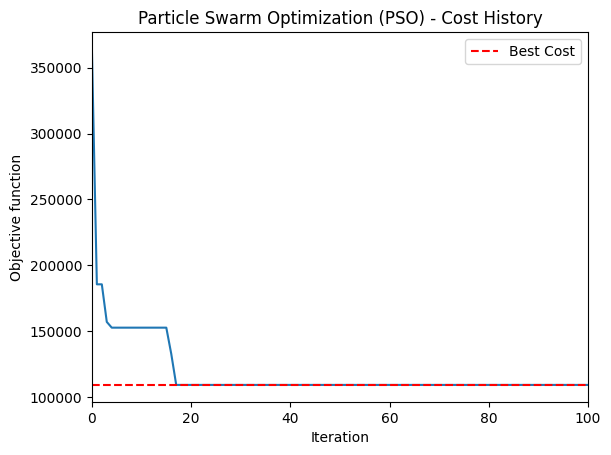

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: 109151.90170863555


In [1677]:
# Plotar gráfico de densidade da otimização
# Seu histórico de custos
cost_history = optimizer.cost_history

# Escalando os valores por uma constante (dividindo por 100 milhões)
scaled_history = [cost / 1.000 for cost in cost_history]

# Custo ótimo (substitua pbest_cost[0] por best_cost)
optimal_cost = best_cost



# Plotagem do gráfico de histórico de custos
plt.plot(scaled_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')

# Adicionar uma linha horizontal no custo ótimo
plt.axhline(optimal_cost / 1.000, color='red', linestyle='--', label='Best Cost')

# Mostrar a legenda
plt.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", best_cost)

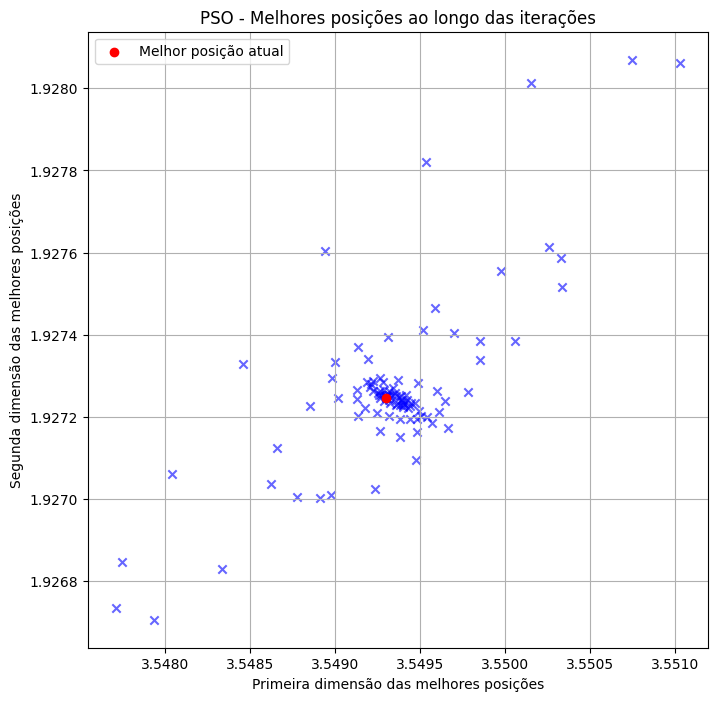

In [1672]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [1673]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_quarto_cenario.csv'

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

melhores_custos_anteriores.append(best_cost)  # Substitua pbest_cost[0] por best_cost

# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_custos_anteriores), best_cost, lamb, beta, theta]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Número de ciclos de manutenção', 'Tempos para manutenções preventivas', 'Severidade para cada subsistema'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)